In [1]:
!pip install deepchem transformers peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 65.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModelForSequenceClassification, RobertaConfig, RobertaForSequenceClassification
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import deepchem as dc
from peft import get_peft_model, LoraConfig, TaskType
import logging
import copy
import sys
import time
import pandas as pd



# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
# Define paths and parameters
TEACHER_MODEL_NAME = "seyonec/ChemBERTa-zinc-base-v1"  # Teacher model
STUDENT_MODEL_NAME = "seyonec/ChemBERTa-zinc-base-v1"  # Student model
OUTPUT_DIR = "kdlora_clintox_model"
MAX_LENGTH = 128
BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 2e-5
TEMPERATURE = 2.0
ALPHA = 0.5  # Weight for distillation loss vs task-specific loss
USE_CUDA = True  # Set to False to use CPU only (more stable but slower)
USE_MIXED_PRECISION = False  # Enable mixed precision training
GRADIENT_ACCUMULATION_STEPS = 4  # Accumulate gradients over multiple steps

# LoRA Configuration
LORA_R = 8  # Rank of LoRA
LORA_ALPHA = 16
LORA_DROPOUT = 0.1

In [4]:
# Create a smaller student model by reducing layers
class SmallerChemBERTa(nn.Module):
    def __init__(self, model_name, num_layers_to_keep=4):
        super(SmallerChemBERTa, self).__init__()
        # Load the base model
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)

        # Store the config for later access
        self.config = self.model.config

        # Reduce the number of layers in the encoder
        original_layers = self.model.roberta.encoder.layer
        self.model.roberta.encoder.layer = nn.ModuleList(
            [original_layers[i] for i in range(min(num_layers_to_keep, len(original_layers)))]
        )

        # Adjust embedding size if needed
        self.hidden_size = self.model.config.hidden_size
        logger.info(f"SmallerChemBERTa created with {num_layers_to_keep} layers and hidden size {self.hidden_size}")

    def forward(self, input_ids=None, attention_mask=None, **kwargs):
        """
        Forward method that accepts all keyword arguments but only uses what the base model needs
        """
        # Only pass the arguments that our base model actually accepts
        # This ensures compatibility with LoRA and other wrappers
        forward_kwargs = {}
        if input_ids is not None:
            forward_kwargs['input_ids'] = input_ids
        if attention_mask is not None:
            forward_kwargs['attention_mask'] = attention_mask

        # Directly call the model with valid arguments only
        outputs = self.model(**forward_kwargs)

        # Create a wrapper object with logits attribute to make it compatible with HF models
        class OutputWrapper:
            def __init__(self, logits):
                self.logits = logits

        # If outputs already has logits attribute, return as is, otherwise wrap it
        if hasattr(outputs, 'logits'):
            return outputs
        else:
            return OutputWrapper(outputs)

In [5]:
class ClinToxDataset(Dataset):
    def __init__(self, data_path, tokenizer, max_length=128, split="train"):
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Load ClinTox dataset from DeepChem
        tasks, datasets, transformers = dc.molnet.load_clintox(splitter='random')
        logger.info(f"ClinTox tasks: {tasks}")  # Log the task names
        train_dataset, valid_dataset, test_dataset = datasets

        # Select appropriate dataset based on split
        if split == "train":
            dataset = train_dataset
        elif split == "valid":
            dataset = valid_dataset
        else:  # test
            dataset = test_dataset

        # Convert to SMILES and labels
        self.smiles = dataset.ids

        # Extract only the second task (CT_TOX - Clinical Trial Toxicity)
        # ClinTox has 2 tasks: FDA_APPROVED (0) and CT_TOX (1)
        self.labels = dataset.y[:, 1:2]  # Keep only the toxicity column
        logger.info(f"Using only clinical trial toxicity task. Label shape: {self.labels.shape}")

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smiles = self.smiles[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            smiles,
            return_tensors="pt",
            max_length=self.max_length,
            padding="max_length",
            truncation=True
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

In [6]:
def distillation_loss(student_logits, teacher_logits, temperature=2.0):
    """
    Compute the knowledge distillation loss using KL divergence
    """
    # Ensure shapes match
    if student_logits.shape != teacher_logits.shape:
        # Log the shape mismatch
        logger.warning(f"Shape mismatch in distillation_loss. Student: {student_logits.shape}, Teacher: {teacher_logits.shape}")

        # Try to reshape
        if student_logits.dim() > teacher_logits.dim():
            student_logits = student_logits.squeeze()
        elif teacher_logits.dim() > student_logits.dim():
            teacher_logits = teacher_logits.squeeze()

        # Check again
        if student_logits.shape != teacher_logits.shape:
            logger.error(f"Failed to match shapes: Student {student_logits.shape}, Teacher {teacher_logits.shape}")
            # Broadcast to match if possible, otherwise return zero loss
            try:
                # Try to use view to match dimensions for binary classification
                if student_logits.dim() == 1 and teacher_logits.dim() == 2:
                    student_logits = student_logits.view(-1, 1)
                elif student_logits.dim() == 2 and teacher_logits.dim() == 1:
                    teacher_logits = teacher_logits.view(-1, 1)

                # Final shape check
                if student_logits.shape != teacher_logits.shape:
                    logger.error("Shapes still don't match, returning zero loss")
                    return torch.tensor(0.0, device=student_logits.device)
            except:
                logger.error("Cannot compute distillation loss due to shape mismatch")
                return torch.tensor(0.0, device=student_logits.device)

    # Apply temperature scaling
    soft_targets = nn.functional.softmax(teacher_logits / temperature, dim=-1)
    soft_prob = nn.functional.log_softmax(student_logits / temperature, dim=-1)

    # KL divergence loss
    kd_loss = -torch.sum(soft_targets * soft_prob, dim=-1).mean() * (temperature ** 2)

    return kd_loss

In [7]:
def create_smaller_model(base_model_name, num_layers=3, hidden_size=384):
    """
    Create a smaller version of a model with fewer layers and smaller hidden size
    """
    # Load the original model's config
    logger.info(f"Loading configuration from {base_model_name}...")
    try:
        smaller_config = RobertaConfig.from_pretrained(base_model_name)
        logger.info(f"Original model configuration: hidden_size={smaller_config.hidden_size}, "
                    f"num_hidden_layers={smaller_config.num_hidden_layers}, "
                    f"num_attention_heads={smaller_config.num_attention_heads}")
    except Exception as e:
        logger.error(f"Error loading model configuration: {e}")
        raise

    # Modify the configuration for a smaller model
    smaller_config.num_hidden_layers = num_layers
    smaller_config.hidden_size = hidden_size
    smaller_config.intermediate_size = hidden_size * 4
    smaller_config.num_attention_heads = max(hidden_size // 64, 1)
    smaller_config.num_labels = 1

    logger.info(f"Creating smaller model with: hidden_size={smaller_config.hidden_size}, "
                f"num_hidden_layers={smaller_config.num_hidden_layers}, "
                f"num_attention_heads={smaller_config.num_attention_heads}")

    # Create a smaller model with the new configuration
    smaller_model = RobertaForSequenceClassification(smaller_config)

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(base_model_name)

    # Get original model for comparison
    original_model = AutoModelForSequenceClassification.from_pretrained(base_model_name, num_labels=1)

    # Log the size reduction
    original_params = sum(p.numel() for p in original_model.parameters())
    smaller_params = sum(p.numel() for p in smaller_model.parameters())
    reduction = (1 - smaller_params / original_params) * 100

    logger.info(f"Original model: {original_params:,} parameters")
    logger.info(f"Smaller model: {smaller_params:,} parameters")
    logger.info(f"Size reduction: {reduction:.2f}%")

    return smaller_model, tokenizer

In [8]:
def setup_lora_model(model):
    """
    Set up a model with LoRA configuration
    """
    # Store the original config and handle custom model classes
    original_config = None

    # For custom model classes, access the internal model
    if isinstance(model, SmallerChemBERTa):
        # Extract the internal model for LoRA to work with
        logger.info("Detected SmallerChemBERTa model, extracting internal model for LoRA")
        internal_model = model.model
        if hasattr(internal_model, 'config'):
            original_config = internal_model.config

        # Identify target modules based on model architecture
        target_modules = []
        for name, _ in internal_model.named_modules():
            if any(key in name for key in ["query", "key", "value", "q_proj", "k_proj", "v_proj"]):
                module_type = name.split(".")[-1]
                if module_type not in target_modules:
                    target_modules.append(module_type)

        logger.info(f"Detected LoRA target modules for SmallerChemBERTa: {target_modules}")

        # If detection fails, use the default
        if not target_modules:
            target_modules = ["query", "value"]

        peft_config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            inference_mode=False,
            r=LORA_R,
            lora_alpha=LORA_ALPHA,
            lora_dropout=LORA_DROPOUT,
            target_modules=target_modules
        )

        # Apply LoRA to the internal model
        logger.info("Applying LoRA to SmallerChemBERTa's internal model")
        lora_model = get_peft_model(internal_model, peft_config)

        # Create a new SmallerChemBERTa instance that wraps the LoRA model
        class LoRASmallerChemBERTa(nn.Module):
            def __init__(self, lora_model, config):
                super().__init__()
                self.model = lora_model
                self.config = config
                self.hidden_size = config.hidden_size

            def forward(self, input_ids=None, attention_mask=None, **kwargs):
                # Only pass what the wrapped model accepts
                forward_kwargs = {}
                if input_ids is not None:
                    forward_kwargs['input_ids'] = input_ids
                if attention_mask is not None:
                    forward_kwargs['attention_mask'] = attention_mask

                return self.model(**forward_kwargs)

        # Create and return the wrapped model
        return LoRASmallerChemBERTa(lora_model, original_config)
    else:
        # Regular model
        if hasattr(model, 'config'):
            original_config = model.config

        # Identify target modules based on model architecture
        target_modules = []
        for name, _ in model.named_modules():
            if any(key in name for key in ["query", "key", "value", "q_proj", "k_proj", "v_proj"]):
                module_type = name.split(".")[-1]
                if module_type not in target_modules:
                    target_modules.append(module_type)

        logger.info(f"Detected LoRA target modules: {target_modules}")

        # If detection fails, use the default
        if not target_modules:
            target_modules = ["query", "value"]

        peft_config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            inference_mode=False,
            r=LORA_R,
            lora_alpha=LORA_ALPHA,
            lora_dropout=LORA_DROPOUT,
            target_modules=target_modules
        )

        # Apply LoRA to the model
        lora_model = get_peft_model(model, peft_config)

        # Make sure the config is accessible
        if original_config is not None:
            lora_model.config = original_config

        return lora_model

In [9]:
def evaluate_model(model, dataloader, device):
    """
    Evaluate the model on a given dataloader
    """
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    criterion = nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            try:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                # Handle both regular models and SmallerChemBERTa
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)

                # Get logits from model output
                if hasattr(outputs, 'logits'):
                    logits = outputs.logits
                else:
                    # For SmallerChemBERTa wrapped with LoRA
                    logits = outputs[0] if isinstance(outputs, tuple) else outputs

                # Check for NaN values
                if torch.isnan(logits).any():
                    logger.warning("NaN values detected in model outputs during evaluation")
                    continue

                loss = criterion(logits, labels)
                total_loss += loss.item()

                predictions = (torch.sigmoid(logits) > 0.5).float()
                correct_predictions += (predictions == labels).sum().item()
                total_predictions += labels.size(0)
            except RuntimeError as e:
                logger.error(f"Error during evaluation: {e}")
                continue

    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    avg_loss = total_loss / len(dataloader) if len(dataloader) > 0 else float('inf')

    return avg_loss, accuracy

In [10]:
def compare_model_sizes(teacher_model, student_model):
    """
    Compare model sizes and print information
    """
    def get_base_model(model):
        if hasattr(model, 'model'):
            return model.model
        return model

    teacher_base = get_base_model(teacher_model)
    student_base = get_base_model(student_model)

    # Count parameters
    teacher_params = sum(p.numel() for p in teacher_model.parameters())
    student_params = sum(p.numel() for p in student_model.parameters())

    # Count trainable parameters in student
    student_trainable = sum(p.numel() for p in student_model.parameters() if p.requires_grad)

    # Get model size in MB
    teacher_size_mb = sum(p.nelement() * p.element_size() for p in teacher_model.parameters()) / (1024 * 1024)
    student_size_mb = sum(p.nelement() * p.element_size() for p in student_model.parameters()) / (1024 * 1024)

    # Calculate reduction
    param_reduction = (1 - student_params / teacher_params) * 100
    size_reduction = (1 - student_size_mb / teacher_size_mb) * 100

    logger.info("\n=== Model Size Comparison ===")
    logger.info(f"Teacher model: {TEACHER_MODEL_NAME}")
    logger.info(f"Student model: Smaller version with LoRA")
    logger.info(f"Teacher parameters: {teacher_params:,} ({teacher_size_mb:.2f} MB)")
    logger.info(f"Student parameters: {student_params:,} ({student_size_mb:.2f} MB)")
    logger.info(f"Student trainable parameters: {student_trainable:,} ({student_trainable/teacher_params*100:.2f}% of teacher)")
    logger.info(f"Parameter reduction: {param_reduction:.2f}%")
    logger.info(f"Size reduction: {size_reduction:.2f}%")

    return {
        "teacher_params": teacher_params,
        "student_params": student_params,
        "student_trainable": student_trainable,
        "teacher_size_mb": teacher_size_mb,
        "student_size_mb": student_size_mb,
        "param_reduction": param_reduction,
        "size_reduction": size_reduction
    }

In [11]:
def train_kdlora():

    # Set up device
    if USE_CUDA and torch.cuda.is_available():
        device = torch.device("cuda")
        logger.info(f"Using GPU: {torch.cuda.get_device_name(0)}")
        logger.info(f"CUDA Version: {torch.version.cuda}")
        logger.info(f"PyTorch CUDA: {torch.backends.cudnn.version()}")
        # Improve GPU memory usage
        torch.backends.cudnn.benchmark = True
    else:
        device = torch.device("cpu")
        logger.info("Using CPU for computation")

    # Create a smaller student model
    logger.info("Creating smaller student model using SmallerChemBERTa...")
    try:
        # Create student model using SmallerChemBERTa class with 4 layers
        student_model_base = SmallerChemBERTa(STUDENT_MODEL_NAME, num_layers_to_keep=4)
        tokenizer = AutoTokenizer.from_pretrained(STUDENT_MODEL_NAME)
        logger.info("Smaller student model created successfully using SmallerChemBERTa")
    except Exception as e:
        logger.error(f"Error creating student model: {e}")
        sys.exit(1)  # Exit if we can't create the student model

    # Load teacher model
    logger.info(f"Loading teacher model: {TEACHER_MODEL_NAME}")
    try:
        teacher_model = AutoModelForSequenceClassification.from_pretrained(
            TEACHER_MODEL_NAME,
            num_labels=1,  # Single binary classification task (toxicity only)
            return_dict=True
        )
        logger.info("Teacher model loaded successfully")
    except Exception as e:
        logger.error(f"Error loading teacher model: {e}")
        sys.exit(1)

    # Setup student model with LoRA
    try:
        logger.info("Adding LoRA adapters to student model...")
        student_model = setup_lora_model(student_model_base)
        logger.info("LoRA adapters added successfully")
    except Exception as e:
        logger.error(f"Error setting up LoRA: {e}")
        sys.exit(1)

    # Compare model sizes
    size_info = compare_model_sizes(teacher_model, student_model)

    # Create datasets
    logger.info("Preparing datasets...")
    try:
        train_dataset = ClinToxDataset("clintox", tokenizer, MAX_LENGTH, split="train")
        val_dataset = ClinToxDataset("clintox", tokenizer, MAX_LENGTH, split="valid")
        test_dataset = ClinToxDataset("clintox", tokenizer, MAX_LENGTH, split="test")

        train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
        logger.info(f"Datasets prepared. Training samples: {len(train_dataset)}")
    except Exception as e:
        logger.error(f"Error preparing datasets: {e}")
        sys.exit(1)

    # Now move models to the selected device
    if device.type == "cuda":
        logger.info("Moving models to GPU...")
        try:
            torch.cuda.empty_cache()
            teacher_model = teacher_model.to(device)
            torch.cuda.empty_cache()
            student_model = student_model.to(device)
            logger.info("Models successfully moved to GPU")
        except Exception as e:
            logger.error(f"Error moving models to GPU: {e}")
            logger.info("Falling back to CPU")
            device = torch.device("cpu")

    teacher_model.eval()

    optimizer = optim.AdamW(student_model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

    task_criterion = nn.BCEWithLogitsLoss()

    train_losses = []
    val_losses = []
    val_accuracies = []

    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # First, verify we can do a forward pass with both models
    logger.info("Testing forward pass with both models...")
    try:
        # Get a batch from the training set
        batch = next(iter(train_dataloader))
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # Test teacher forward pass
        with torch.no_grad():
            teacher_outputs = teacher_model(input_ids=input_ids, attention_mask=attention_mask)

            # Extract logits from teacher outputs
            if hasattr(teacher_outputs, 'logits'):
                teacher_logits = teacher_outputs.logits
            else:
                teacher_logits = teacher_outputs[0] if isinstance(teacher_outputs, tuple) else teacher_outputs

            logger.info(f"Teacher logits shape: {teacher_logits.shape}")

        # Test student forward pass
        student_outputs = student_model(input_ids=input_ids, attention_mask=attention_mask)

        # Extract logits from student outputs
        if hasattr(student_outputs, 'logits'):
            student_logits = student_outputs.logits
        else:
            student_logits = student_outputs[0] if isinstance(student_outputs, tuple) else student_outputs

        logger.info(f"Student logits shape: {student_logits.shape}")

        # Check if logits have the expected shape for binary classification
        assert student_logits.dim() == 2 and student_logits.size(1) == 1, f"Expected student logits shape [batch_size, 1], got {student_logits.shape}"
        assert teacher_logits.dim() == 2 and teacher_logits.size(1) == 1, f"Expected teacher logits shape [batch_size, 1], got {teacher_logits.shape}"

        logger.info("Forward pass test completed successfully")
    except Exception as e:
        logger.error(f"Error during forward pass test: {e}")
        logger.error("Cannot proceed with training due to model incompatibility")
        sys.exit(1)

    logger.info(f"Evaluating teacher model on validation set...")
    try:
        teacher_val_loss, teacher_val_accuracy = evaluate_model(teacher_model, val_dataloader, device)
        logger.info(f"Teacher model - Validation Loss: {teacher_val_loss:.4f}, Accuracy: {teacher_val_accuracy:.4f}")
    except Exception as e:
        logger.error(f"Error evaluating teacher model: {e}")
        teacher_val_loss, teacher_val_accuracy = float('inf'), 0.0

    # Create gradient scaler for mixed precision training
    scaler = torch.cuda.amp.GradScaler() if USE_MIXED_PRECISION and device.type == "cuda" else None

    # Training loop
    for epoch in range(EPOCHS):
        student_model.train()
        total_train_loss = 0
        batch_count = 0

        # Reset accumulated gradients at start of epoch
        optimizer.zero_grad()

        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")
        for batch_idx, batch in enumerate(progress_bar):
            try:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                # Teacher forward pass
                with torch.no_grad():
                    teacher_outputs = teacher_model(input_ids=input_ids, attention_mask=attention_mask)
                    teacher_logits = teacher_outputs.logits

                # Student forward pass with mixed precision
                if USE_MIXED_PRECISION and device.type == "cuda":
                    with torch.cuda.amp.autocast():
                        student_outputs = student_model(input_ids=input_ids, attention_mask=attention_mask)

                        # Get student logits
                        if hasattr(student_outputs, 'logits'):
                            student_logits = student_outputs.logits
                        else:
                            # For SmallerChemBERTa wrapped with LoRA
                            student_logits = student_outputs[0] if isinstance(student_outputs, tuple) else student_outputs

                        # Check for NaN values
                        if torch.isnan(student_logits).any() or torch.isnan(teacher_logits).any():
                            logger.warning(f"NaN values detected at batch {batch_idx}, skipping")
                            continue

                        # Compute losses
                        task_loss = task_criterion(student_logits, labels)
                        kd_loss = distillation_loss(student_logits, teacher_logits, TEMPERATURE)

                        # Combined loss
                        loss = ALPHA * kd_loss + (1 - ALPHA) * task_loss
                        loss = loss / GRADIENT_ACCUMULATION_STEPS  # Scale loss for gradient accumulation

                    # Backward with scaler
                    scaler.scale(loss).backward()

                    # Only step optimizer after accumulating gradients
                    if (batch_idx + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
                        # Gradient clipping with scaler
                        scaler.unscale_(optimizer)
                        torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)

                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()
                else:
                    student_outputs = student_model(input_ids=input_ids, attention_mask=attention_mask)

                    # Get student logits
                    if hasattr(student_outputs, 'logits'):
                        student_logits = student_outputs.logits
                    else:
                        # For SmallerChemBERTa wrapped with LoRA
                        student_logits = student_outputs[0] if isinstance(student_outputs, tuple) else student_outputs

                    # Check for NaN values
                    if torch.isnan(student_logits).any() or torch.isnan(teacher_logits).any():
                        logger.warning(f"NaN values detected at batch {batch_idx}, skipping")
                        continue

                    # Compute losses
                    task_loss = task_criterion(student_logits, labels)
                    kd_loss = distillation_loss(student_logits, teacher_logits, TEMPERATURE)

                    # Combined loss
                    loss = ALPHA * kd_loss + (1 - ALPHA) * task_loss
                    loss = loss / GRADIENT_ACCUMULATION_STEPS  # Scale loss for gradient accumulation

                    loss.backward()

                    # Only step optimizer after accumulating gradients
                    if (batch_idx + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
                        # Gradient clipping
                        torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)

                        optimizer.step()
                        optimizer.zero_grad()

                total_train_loss += loss.item() * GRADIENT_ACCUMULATION_STEPS  # Scale back the loss for reporting
                batch_count += 1
                progress_bar.set_postfix({"loss": loss.item() * GRADIENT_ACCUMULATION_STEPS})

            except RuntimeError as e:
                logger.error(f"Error during training at epoch {epoch+1}, batch {batch_idx}: {e}")
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                continue

        # Calculate metrics
        if batch_count > 0:
            avg_train_loss = total_train_loss / batch_count
            train_losses.append(avg_train_loss)

            # Evaluate
            logger.info(f"Evaluating student model on validation set...")
            try:
                val_loss, val_accuracy = evaluate_model(student_model, val_dataloader, device)
                val_losses.append(val_loss)
                val_accuracies.append(val_accuracy)

                logger.info(f"Epoch {epoch+1}/{EPOCHS}")
                logger.info(f"Train Loss: {avg_train_loss:.4f}")
                logger.info(f"Val Loss: {val_loss:.4f}")
                logger.info(f"Val Accuracy: {val_accuracy:.4f}")
            except Exception as e:
                logger.error(f"Error during validation at epoch {epoch+1}: {e}")
                val_loss, val_accuracy = float('inf'), 0.0
                val_losses.append(val_loss)
                val_accuracies.append(val_accuracy)

            # Save checkpoint
            checkpoint_path = os.path.join(OUTPUT_DIR, f"checkpoint_epoch_{epoch+1}.pt")
            torch.save({
                'epoch': epoch,
                'model_state_dict': student_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': val_loss,
            }, checkpoint_path)

    # Final evaluation on test set
    logger.info("Evaluating final model on test set...")
    try:
        test_loss, test_accuracy = evaluate_model(student_model, test_dataloader, device)
        logger.info(f"Test Loss: {test_loss:.4f}")
        logger.info(f"Test Accuracy: {test_accuracy:.4f}")
    except Exception as e:
        logger.error(f"Error during final test evaluation: {e}")
        test_loss, test_accuracy = float('inf'), 0.0

    # Also evaluate the teacher on test set
    logger.info("Evaluating teacher model on test set for comparison...")
    try:
        teacher_test_loss, teacher_test_accuracy = evaluate_model(teacher_model, test_dataloader, device)
        logger.info(f"Teacher Test Loss: {teacher_test_loss:.4f}")
        logger.info(f"Teacher Test Accuracy: {teacher_test_accuracy:.4f}")
    except Exception as e:
        logger.error(f"Error evaluating teacher model on test set: {e}")
        teacher_test_loss, teacher_test_accuracy = float('inf'), 0.0

    # Save final model
    try:
        student_model.save_pretrained(OUTPUT_DIR)
        tokenizer.save_pretrained(OUTPUT_DIR)
        logger.info(f"Model saved to {OUTPUT_DIR}")
    except Exception as e:
        logger.error(f"Error saving model: {e}")

    # Plot training metrics
    if len(train_losses) > 0:
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
        plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy')
        plt.axhline(y=teacher_val_accuracy, color='r', linestyle='--', label='Teacher Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Validation Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, 'training_metrics.png'))
        plt.close()

    # Model comparison metrics
    size_info = compare_model_sizes(teacher_model, student_model)

    logger.info("\n=== Model Performance Comparison ===")
    logger.info(f"Teacher model parameters: {size_info['teacher_params']:,}")
    logger.info(f"Student model parameters: {size_info['student_params']:,}")
    logger.info(f"Trainable parameters: {size_info['student_trainable']:,} ({size_info['student_trainable']/size_info['teacher_params']*100:.2f}% of teacher)")
    logger.info(f"Size reduction: {size_info['size_reduction']:.2f}%")

    if len(val_accuracies) > 0:
        logger.info(f"Final validation accuracy: {val_accuracies[-1]:.4f}")
        logger.info(f"Teacher validation accuracy: {teacher_val_accuracy:.4f}")
        logger.info(f"Accuracy retention: {(val_accuracies[-1]/teacher_val_accuracy)*100:.2f}% (>100% means improvement)")

    logger.info(f"Final test accuracy: {test_accuracy:.4f}")
    logger.info(f"Teacher test accuracy: {teacher_test_accuracy:.4f}")

    # Save comparison results
    with open(os.path.join(OUTPUT_DIR, 'model_comparison.txt'), 'w') as f:
        f.write("=== Model Size Comparison ===\n")
        f.write(f"Teacher model: {TEACHER_MODEL_NAME}\n")
        f.write(f"Student model: Smaller version with LoRA\n")
        f.write(f"Teacher parameters: {size_info['teacher_params']:,} ({size_info['teacher_size_mb']:.2f} MB)\n")
        f.write(f"Student parameters: {size_info['student_params']:,} ({size_info['student_size_mb']:.2f} MB)\n")
        f.write(f"Student trainable parameters: {size_info['student_trainable']:,} ({size_info['student_trainable']/size_info['teacher_params']*100:.2f}% of teacher)\n")
        f.write(f"Parameter reduction: {size_info['param_reduction']:.2f}%\n")
        f.write(f"Size reduction: {size_info['size_reduction']:.2f}%\n\n")

        f.write("=== Model Performance Comparison ===\n")
        f.write(f"Trainable parameters: {size_info['student_trainable']:,} ({size_info['student_trainable']/size_info['teacher_params']*100:.2f}% of teacher)\n")

        if len(val_accuracies) > 0:
            f.write(f"Final validation accuracy: {val_accuracies[-1]:.4f}\n")
            f.write(f"Teacher validation accuracy: {teacher_val_accuracy:.4f}\n")
            f.write(f"Accuracy retention: {(val_accuracies[-1]/teacher_val_accuracy)*100:.2f}%\n")

        f.write(f"Final test accuracy: {test_accuracy:.4f}\n")
        f.write(f"Teacher test accuracy: {teacher_test_accuracy:.4f}\n")

In [12]:
if __name__ == "__main__":
    train_kdlora()

config.json:   0%|          | 0.00/501 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/9.43k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/3.21k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[21:22:32] DEPRECATION WARNING: please use MorganGenerator
[21:22:32] DEPRECATION WARNING: please use MorganGenerator
[21:22:32] DEPRECATION WARNING: please use MorganGenerator
[21:22:32] DEPRECATION WARNING: please use MorganGenerator
[21:22:32] DEPRECATION WARNING: please use MorganGenerator
[21:22:32] DEPRECATION WARNING: please use MorganGenerator
[21:22:32] DEPRECATION WARNING: please use MorganGenerator
[21:22:32] Explicit valence for atom # 0 N, 5, is greater than permitted
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool break

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'cla

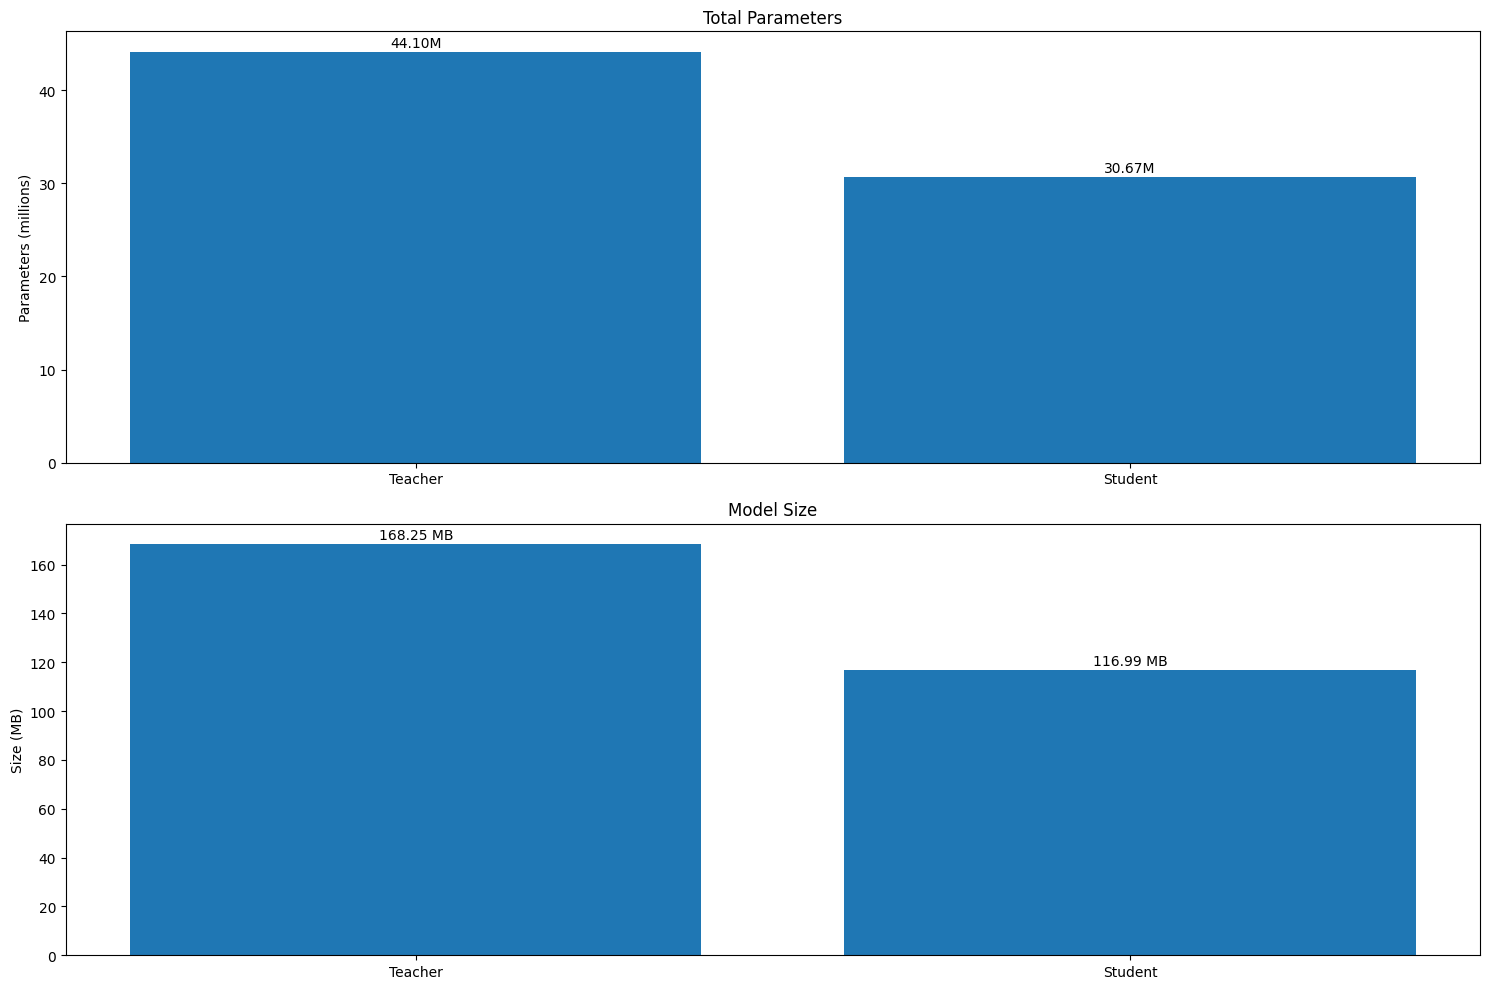

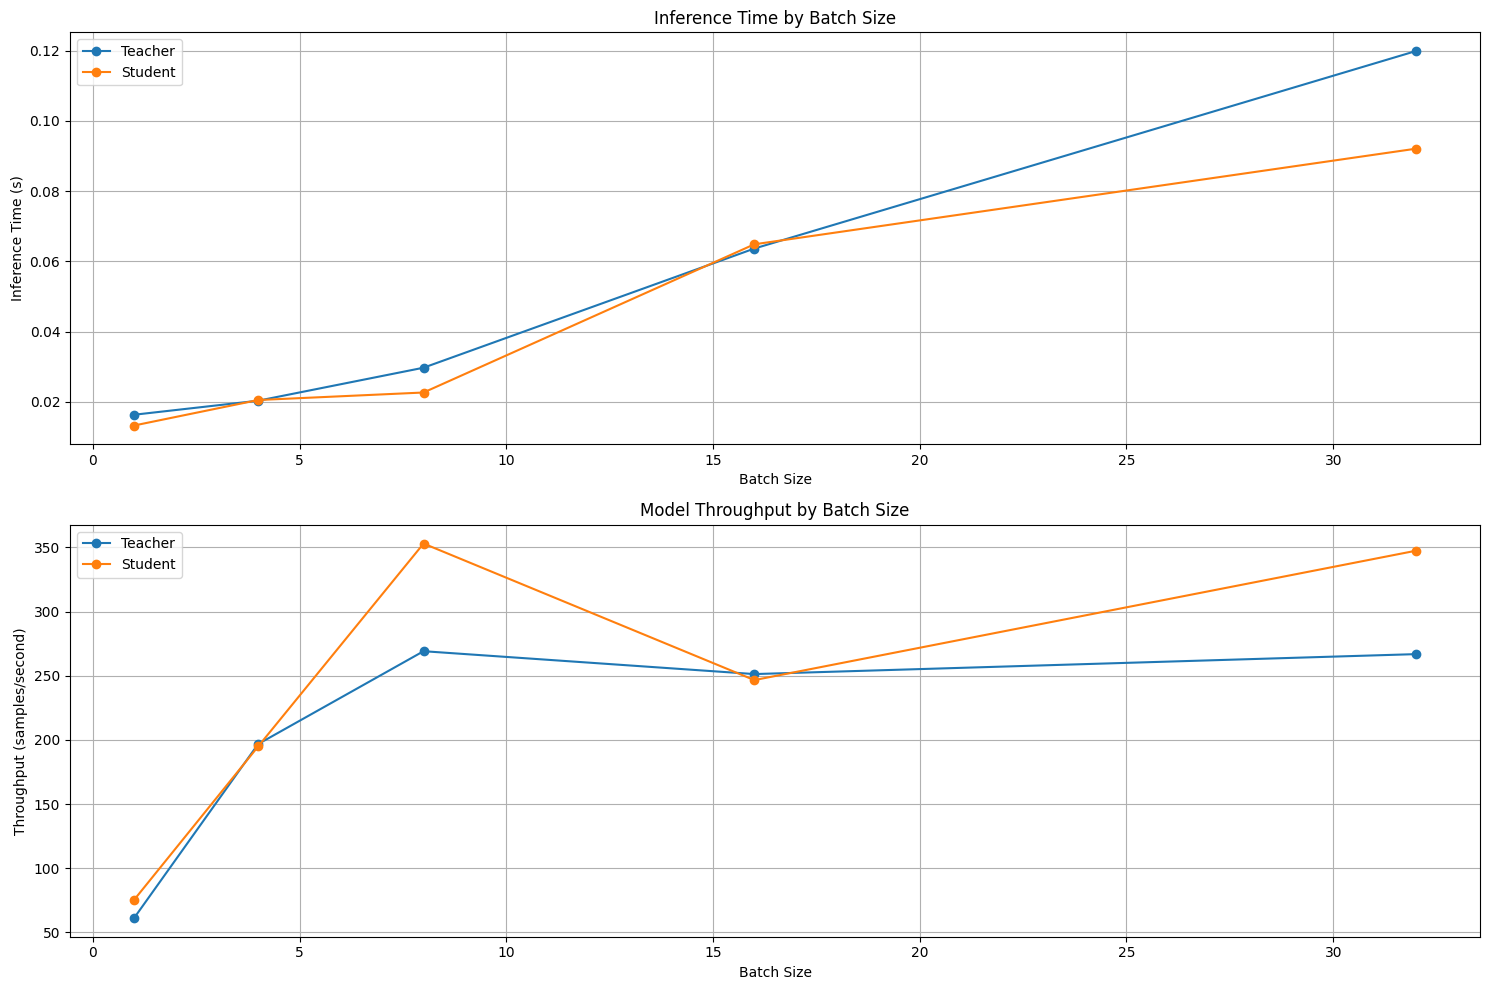

In [13]:
#Student and Teacher Model Evaluation

BENCHMARK_DIR = "kdlora_benchmark_results"
USE_CUDA = torch.cuda.is_available()
NUM_INFERENCE_RUNS = 50  # More runs for statistical significance
INFERENCE_BATCH_SIZES = [1, 4, 8, 16, 32]  # Test various batch sizes

# Create output directory
os.makedirs(BENCHMARK_DIR, exist_ok=True)

def load_or_create_models():
    """Load or create the teacher and student models"""
    device = torch.device("cuda" if USE_CUDA else "cpu")

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(TEACHER_MODEL_NAME)

    # Load teacher model
    logger.info(f"Loading teacher model: {TEACHER_MODEL_NAME}")
    teacher_model = AutoModelForSequenceClassification.from_pretrained(
        TEACHER_MODEL_NAME,
        num_labels=1,
        return_dict=True
    )
    teacher_model = teacher_model.to(device)

    # Create student model
    logger.info(f"Creating student model with LoRA")
    student_base = SmallerChemBERTa(STUDENT_MODEL_NAME, num_layers_to_keep=4)
    student_model = setup_lora_model(student_base)
    student_model = student_model.to(device)

    return teacher_model, student_model, tokenizer

def count_parameters(model):
    """Count the parameters of a model"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Model size in MB
    model_size_mb = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024 * 1024)

    return {
        "total_params": total_params,
        "trainable_params": trainable_params,
        "model_size_mb": model_size_mb
    }

def measure_inference_time(model, dataloader, device, num_runs=10):
    """Measure inference time"""
    model.eval()
    batch_size = dataloader.batch_size
    inference_times = []

    # Get a batch for testing
    batch = next(iter(dataloader))
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)

    # Warm-up run
    with torch.no_grad():
        _ = model(input_ids=input_ids, attention_mask=attention_mask)

    # Timed runs
    for _ in range(num_runs):
        start_time = time.time()
        with torch.no_grad():
            _ = model(input_ids=input_ids, attention_mask=attention_mask)

        # Make sure GPU operations are completed
        if device.type == "cuda":
            torch.cuda.synchronize()

        end_time = time.time()
        inference_times.append(end_time - start_time)

    avg_time = sum(inference_times) / len(inference_times)
    throughput = batch_size / avg_time

    return {
        "avg_time": avg_time,
        "throughput": throughput,
        "times": inference_times
    }

def benchmark_inference():
    """Benchmark inference for teacher and student models with various batch sizes"""
    device = torch.device("cuda" if USE_CUDA else "cpu")
    teacher_model, student_model, tokenizer = load_or_create_models()

    results = {
        "model": [],
        "batch_size": [],
        "avg_inference_time": [],
        "throughput": []
    }

    # Prepare test dataset
    test_dataset = ClinToxDataset("clintox", tokenizer, MAX_LENGTH, split="test")

    for batch_size in INFERENCE_BATCH_SIZES:
        logger.info(f"Testing with batch size {batch_size}")

        test_dataloader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False
        )

        # Measure teacher model
        logger.info(f"Measuring teacher model inference time (batch size {batch_size})...")
        teacher_results = measure_inference_time(
            teacher_model,
            test_dataloader,
            device,
            NUM_INFERENCE_RUNS
        )

        results["model"].append("Teacher")
        results["batch_size"].append(batch_size)
        results["avg_inference_time"].append(teacher_results["avg_time"])
        results["throughput"].append(teacher_results["throughput"])

        logger.info(f"Teacher model: Avg time {teacher_results['avg_time']:.4f}s, "
                    f"Throughput {teacher_results['throughput']:.2f} samples/s")

        # Measure student model
        logger.info(f"Measuring student model inference time (batch size {batch_size})...")
        student_results = measure_inference_time(
            student_model,
            test_dataloader,
            device,
            NUM_INFERENCE_RUNS
        )

        results["model"].append("Student")
        results["batch_size"].append(batch_size)
        results["avg_inference_time"].append(student_results["avg_time"])
        results["throughput"].append(student_results["throughput"])

        logger.info(f"Student model: Avg time {student_results['avg_time']:.4f}s, "
                    f"Throughput {student_results['throughput']:.2f} samples/s")

        # Calculate speedup
        speedup = teacher_results["avg_time"] / student_results["avg_time"]
        logger.info(f"Speedup: {speedup:.2f}x")

    # Convert to dataframe and save
    results_df = pd.DataFrame(results)
    results_df.to_csv(os.path.join(BENCHMARK_DIR, "inference_results.csv"), index=False)

    # Create plots
    plot_inference_results(results_df)

    return results_df

def plot_inference_results(results_df):
    """Plot the inference results"""
    plt.figure(figsize=(15, 10))

    # Plot 1: Inference time
    plt.subplot(2, 1, 1)
    for model_name in ["Teacher", "Student"]:
        model_data = results_df[results_df["model"] == model_name]
        plt.plot(model_data["batch_size"], model_data["avg_inference_time"],
                marker='o', label=model_name)

    plt.xlabel("Batch Size")
    plt.ylabel("Inference Time (s)")
    plt.title("Inference Time by Batch Size")
    plt.grid(True)
    plt.legend()

    # Plot 2: Throughput
    plt.subplot(2, 1, 2)
    for model_name in ["Teacher", "Student"]:
        model_data = results_df[results_df["model"] == model_name]
        plt.plot(model_data["batch_size"], model_data["throughput"],
                marker='o', label=model_name)

    plt.xlabel("Batch Size")
    plt.ylabel("Throughput (samples/second)")
    plt.title("Model Throughput by Batch Size")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(BENCHMARK_DIR, "inference_comparison.png"))

def estimate_training_time():
    """Estimate training time for one epoch of KD-LoRA"""
    device = torch.device("cuda" if USE_CUDA else "cpu")
    teacher_model, student_model, tokenizer = load_or_create_models()

    # Create criterion and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(student_model.parameters(), lr=LEARNING_RATE)

    # Load datasets
    train_dataset = ClinToxDataset("clintox", tokenizer, MAX_LENGTH, split="train")
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True
    )

    # Prepare for training simulation
    logger.info("Simulating one epoch of training to measure time...")
    teacher_model.eval()
    student_model.train()

    # Simulate one epoch with timing
    total_batches = len(train_dataloader)
    batch_times = []

    # Start timing
    start_time = time.time()

    for batch_idx, batch in enumerate(tqdm(train_dataloader, desc="Simulating training")):
        # Only process a subset of batches to save time
        if batch_idx > total_batches // 4:  # Process 25% of the batches
            break

        # Get batch data
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Measure batch time
        batch_start = time.time()

        with torch.no_grad():
            teacher_outputs = teacher_model(input_ids=input_ids, attention_mask=attention_mask)
            teacher_logits = teacher_outputs.logits

        student_outputs = student_model(input_ids=input_ids, attention_mask=attention_mask)
        if hasattr(student_outputs, 'logits'):
            student_logits = student_outputs.logits
        else:
            student_logits = student_outputs[0] if isinstance(student_outputs, tuple) else student_outputs

        # Compute loss (simplified)
        loss = criterion(student_logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_end = time.time()
        batch_times.append(batch_end - batch_start)

    end_time = time.time()
    total_time = end_time - start_time

    # Extrapolate to full epoch
    avg_batch_time = sum(batch_times) / len(batch_times)
    estimated_epoch_time = avg_batch_time * total_batches
    estimated_total_time = estimated_epoch_time * EPOCHS

    logger.info(f"Average batch time: {avg_batch_time:.4f}s")
    logger.info(f"Estimated time per epoch: {estimated_epoch_time:.2f}s ({estimated_epoch_time/60:.2f} min)")
    logger.info(f"Estimated total training time for {EPOCHS} epochs: {estimated_total_time/60:.2f} min")

    training_data = {
        "avg_batch_time": avg_batch_time,
        "batches_per_epoch": total_batches,
        "estimated_epoch_time": estimated_epoch_time,
        "total_epochs": EPOCHS,
        "estimated_total_time": estimated_total_time,
        "estimated_total_time_min": estimated_total_time / 60
    }

    # Save to CSV
    pd.DataFrame([training_data]).to_csv(
        os.path.join(BENCHMARK_DIR, "training_time_estimate.csv"),
        index=False
    )

    return training_data

def compare_model_sizes():
    """Compare the sizes of teacher and student models"""
    teacher_model, student_model, _ = load_or_create_models()

    teacher_params = count_parameters(teacher_model)
    student_params = count_parameters(student_model)

    param_reduction = (1 - student_params["total_params"] / teacher_params["total_params"]) * 100
    size_reduction = (1 - student_params["model_size_mb"] / teacher_params["model_size_mb"]) * 100

    logger.info(f"Teacher model: {teacher_params['total_params']:,} parameters, {teacher_params['model_size_mb']:.2f} MB")
    logger.info(f"Student model: {student_params['total_params']:,} parameters, {student_params['model_size_mb']:.2f} MB")
    logger.info(f"Student trainable: {student_params['trainable_params']:,} parameters")
    logger.info(f"Parameter reduction: {param_reduction:.2f}%")
    logger.info(f"Size reduction: {size_reduction:.2f}%")

    size_data = {
        "model": ["Teacher", "Student"],
        "total_params": [teacher_params["total_params"], student_params["total_params"]],
        "trainable_params": [teacher_params["trainable_params"], student_params["trainable_params"]],
        "model_size_mb": [teacher_params["model_size_mb"], student_params["model_size_mb"]],
        "param_reduction": [0, param_reduction],
        "size_reduction": [0, size_reduction]
    }

    size_df = pd.DataFrame(size_data)
    size_df.to_csv(os.path.join(BENCHMARK_DIR, "model_sizes.csv"), index=False)

    plot_model_sizes(size_df)

    return size_df

def plot_model_sizes(size_df):
    """Plot model size comparison"""
    plt.figure(figsize=(15, 10))

    # Plot 1: Total parameters
    plt.subplot(2, 1, 1)
    plt.bar(size_df["model"], size_df["total_params"] / 1_000_000)
    plt.ylabel("Parameters (millions)")
    plt.title("Total Parameters")

    # Add value labels
    for i, v in enumerate(size_df["total_params"]):
        plt.text(i, v/1_000_000 + 0.5, f"{v/1_000_000:.2f}M", ha='center')

    # Plot 2: Model size
    plt.subplot(2, 1, 2)
    plt.bar(size_df["model"], size_df["model_size_mb"])
    plt.ylabel("Size (MB)")
    plt.title("Model Size")

    # Add value labels
    for i, v in enumerate(size_df["model_size_mb"]):
        plt.text(i, v + 2, f"{v:.2f} MB", ha='center')

    plt.tight_layout()
    plt.savefig(os.path.join(BENCHMARK_DIR, "model_size_comparison.png"))

def create_report():
    """Create a comprehensive benchmark report"""
    logger.info("Starting benchmarking process...")

    logger.info("\n=== Comparing Model Sizes ===")
    size_results = compare_model_sizes()

    logger.info("\n=== Estimating Training Time ===")
    training_time = estimate_training_time()

    logger.info("\n=== Benchmarking Inference ===")
    inference_results = benchmark_inference()

    # Create markdown report
    with open(os.path.join(BENCHMARK_DIR, "kdlora_benchmark_report.md"), "w") as f:
        f.write("# KD-LoRA Benchmarking Report\n\n")

        f.write("## Model Size Comparison\n\n")
        f.write(size_results.to_markdown(index=False))
        f.write("\n\n")

        f.write("## Training Time Estimation\n\n")
        f.write(f"- Average batch processing time: {training_time['avg_batch_time']:.4f} seconds\n")
        f.write(f"- Batches per epoch: {training_time['batches_per_epoch']}\n")
        f.write(f"- Estimated time per epoch: {training_time['estimated_epoch_time']:.2f} seconds ({training_time['estimated_epoch_time']/60:.2f} minutes)\n")
        f.write(f"- Total epochs: {training_time['total_epochs']}\n")
        f.write(f"- Estimated total training time: {training_time['estimated_total_time_min']:.2f} minutes\n\n")

        # Inference section
        f.write("## Inference Time Comparison\n\n")

        pivot_df = inference_results.pivot(index='model', columns='batch_size', values='avg_inference_time')
        f.write("### Average Inference Time (seconds)\n\n")
        f.write(pivot_df.to_markdown())
        f.write("\n\n")

        pivot_df = inference_results.pivot(index='model', columns='batch_size', values='throughput')
        f.write("### Throughput (samples/second)\n\n")
        f.write(pivot_df.to_markdown())
        f.write("\n\n")

        f.write("### Inference Speedup (Teacher vs Student)\n\n")
        f.write("| Batch Size | Speedup |\n")
        f.write("|------------|--------|\n")

        for batch_size in INFERENCE_BATCH_SIZES:
            teacher_time = inference_results[(inference_results["model"] == "Teacher") &
                                           (inference_results["batch_size"] == batch_size)]["avg_inference_time"].values[0]
            student_time = inference_results[(inference_results["model"] == "Student") &
                                           (inference_results["batch_size"] == batch_size)]["avg_inference_time"].values[0]
            speedup = teacher_time / student_time
            f.write(f"| {batch_size} | {speedup:.2f}x |\n")

    logger.info(f"Benchmark report saved to {os.path.join(BENCHMARK_DIR, 'kdlora_benchmark_report.md')}")

if __name__ == "__main__":
    create_report()